In [64]:
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt

#Load CNN modules
from keras.utils import to_categorical
import tensorflow as tf
import keras

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [65]:
import scipy.io as scio

data = scio.loadmat('data_all_env.mat')

In [66]:
all_env_data = data.get('all_env_data')
all_env_labels = data.get('all_env_labels')
all_env_labels = np.delete(all_env_labels,1)
modes = {'idle','walk','stand','stairascent','stairdescent','rampascent','rampdescent'};

In [67]:
i = np.argsort(all_env_labels)
dataSort = all_env_data[i]
labelSort = all_env_labels[i]
labelDif = labelSort[1:] - labelSort[:-1]
breaks = np.where(abs(labelDif) > 0)[0]+1
dataClass = np.split(dataSort,breaks)
classes = np.split(labelSort,breaks)

In [68]:
sizes = []
train_X = []
test_X = []
valid_X = []

for classData in dataClass:
    #sizes.append(np.size(i))
    stop1 = np.floor(np.size(classData,0)*0.7).astype(int)
    stop2 = np.floor(np.size(classData,0)*0.85).astype(int)
    train_X.extend(classData[0:stop1])
    test_X.extend(classData[stop1:stop2])
    valid_X.extend(classData[stop2:len(classData)])
    
np.random.seed(10)
ish = list(np.arange(len(train_X)))
np.random.shuffle(ish)
ishtr = np.array(ish)

ish = list(np.arange(len(test_X)))
np.random.shuffle(ish)
ishte = np.array(ish)
           
ish = list(np.arange(len(valid_X)))
np.random.shuffle(ish)
ishva = np.array(ish)

train_X = np.array(train_X, dtype="object")
test_X = np.array(test_X, dtype="object")
valid_X = np.array(valid_X, dtype="object")

train_X = train_X[ishtr]
test_X = test_X[ishte]
valid_X = valid_X[ishva]

In [69]:
train_Y = []
test_Y = []
valid_Y = []


for classData in classes:
    stop1 = np.floor(np.size(classData,0)*0.7).astype(int)
    stop2 = np.floor(np.size(classData,0)*0.85).astype(int)
    train_Y.extend(classData[0:stop1])
    test_Y.extend(classData[stop1:stop2])
    valid_Y.extend(classData[stop2:len(classData)])
    
train_Y = np.array(train_Y, dtype="object")
test_Y = np.array(test_Y, dtype="object")
valid_Y = np.array(valid_Y, dtype="object")

train_Y = train_Y[ishtr]
test_Y = test_Y[ishte]
valid_Y = valid_Y[ishva]

In [70]:
print(np.shape(train_X))
print(np.shape(test_X))
print(np.shape(valid_X))
print(np.shape(train_Y))
print(np.shape(test_Y))
print(np.shape(valid_Y))

(179255, 44)
(38413, 44)
(38416, 44)
(179255,)
(38413,)
(38416,)


Text(0.5, 1.0, 'Ground Truth : 3')

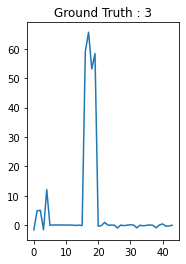

In [71]:
plt.subplot(121)
plt.plot(train_X[0])
plt.title("Ground Truth : {}".format(train_Y[0]))

In [72]:
train_Y_one_hot = to_categorical(train_Y-1)

print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])
        
test_Y_one_hot = to_categorical(test_Y-1)

print('Original label:', test_Y[0])
print('After conversion to one-hot:', test_Y_one_hot[0])

valid_Y_one_hot = to_categorical(valid_Y-1)

print('Original label:', valid_Y[0])
print('After conversion to one-hot:', valid_Y_one_hot[0])

Original label: 3
After conversion to one-hot: [0. 0. 1. 0. 0. 0. 0.]
Original label: 1
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0.]
Original label: 2
After conversion to one-hot: [0. 1. 0. 0. 0. 0. 0.]


In [73]:
#from sklearn.model_selection import train_test_split
#train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

train_X = train_X[:,np.newaxis]
valid_X = valid_X[:,np.newaxis]
test_X = test_X[:,np.newaxis]
train_label = train_Y_one_hot
valid_label = valid_Y_one_hot
test_label = test_Y_one_hot

In [74]:
train_X.shape,valid_X.shape,test_X.shape,train_label.shape,valid_label.shape,test_label.shape

((179255, 1, 44),
 (38416, 1, 44),
 (38413, 1, 44),
 (179255, 7),
 (38416, 7),
 (38413, 7))

In [75]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [76]:
batch_size = 32
epochs = 30
num_classes = len(set(train_Y))

In [77]:
model = Sequential()
model.add(Conv1D(32, kernel_size=3,activation='linear',input_shape=(1, 44),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D((2),padding='same'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Conv1D(64, (3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2),padding='same'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Conv1D(128, (3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling1D(pool_size=(2),padding='same'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [78]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.00001),metrics=['accuracy'])

In [79]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1, 32)             4256      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 1, 32)             0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1, 32)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 64)             6208      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 1, 64)             0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1, 128)           

In [80]:
train = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 179255 samples, validate on 38416 samples
Epoch 1/30
179255/179255 [==============================] - 34s 189us/step - loss: 1.3493 - accuracy: 0.5036 - val_loss: 0.9844 - val_accuracy: 0.6525
Epoch 2/30
179255/179255 [==============================] - 34s 191us/step - loss: 0.7895 - accuracy: 0.7382 - val_loss: 0.6681 - val_accuracy: 0.7727
Epoch 3/30
179255/179255 [==============================] - 33s 186us/step - loss: 0.5370 - accuracy: 0.8305 - val_loss: 0.5464 - val_accuracy: 0.8139
Epoch 4/30
179255/179255 [==============================] - 33s 186us/step - loss: 0.4219 - accuracy: 0.8663 - val_loss: 0.4840 - val_accuracy: 0.8372
Epoch 5/30
179255/179255 [==============================] - 34s 191us/step - loss: 0.3547 - accuracy: 0.8883 - val_loss: 0.4437 - val_accuracy: 0.8570
Epoch 6/30
179255/179255 [==============================] - 34s 192us/step - loss: 0.3107 - accuracy: 0.9027 - val_loss: 0.4184 - val_accuracy: 0.8709
Epoch 7/30
179255/179255 [=================

In [81]:
test_eval = model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [82]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.2796675629253713
Test accuracy: 0.9265612959861755


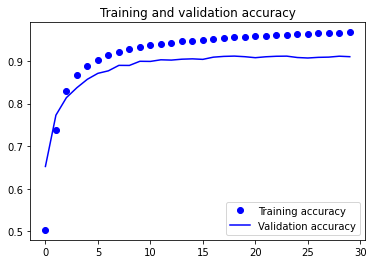

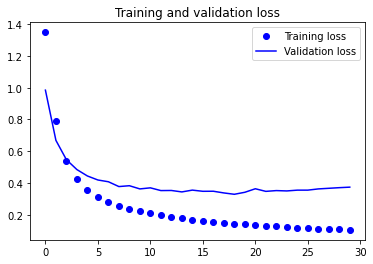

In [83]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [88]:
model.save('model_4_1')